## 세탁 라벨 분류 CNN 모델
세탁 라벨을 찍으면 그를 통해 라벨을 분류하는 CNN 모델입니다.

[이 분](https://github.com/cpprhtn)과 [이 글](https://debuggercafe.com/multi-label-image-classification-with-pytorch-and-deep-learning/)의 큰 도움을 받았습니다.

In [1]:
import torch
import cv2
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import models as models
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test, path='/content/drive/MyDrive/train/v2/train'):
        self.csv = csv
        self.train = train
        self.test = test
        self.path = path

        self.all_image_names = self.csv[:]['id']
        self.all_labels = np.array(self.csv.drop(['id', 'type'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.path}/{self.image_names[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [3]:
def model_f(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 6)
    return model

In [4]:
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [5]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

In [6]:
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model_f(pretrained=True, requires_grad=False).to(device)

lr = 0.0001
epochs = 20
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [7]:
train_csv = pd.read_csv('/content/drive/MyDrive/train/v2/data.csv')
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 5525
Number of validation images: 975


In [8]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 20
Training


  0%|          | 0/172 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
173it [19:04,  6.62s/it]


Validating


31it [02:59,  5.79s/it]


Train Loss: 0.5702
Val Loss: 0.5614
Epoch 2 of 20
Training


173it [07:42,  2.67s/it]


Validating


31it [01:07,  2.18s/it]


Train Loss: 0.4671
Val Loss: 0.5160
Epoch 3 of 20
Training


173it [07:43,  2.68s/it]


Validating


31it [01:07,  2.17s/it]


Train Loss: 0.4196
Val Loss: 0.4744
Epoch 4 of 20
Training


173it [07:44,  2.68s/it]


Validating


31it [01:07,  2.17s/it]


Train Loss: 0.3870
Val Loss: 0.4561
Epoch 5 of 20
Training


173it [07:41,  2.67s/it]


Validating


31it [01:07,  2.16s/it]


Train Loss: 0.3642
Val Loss: 0.4272
Epoch 6 of 20
Training


173it [07:41,  2.67s/it]


Validating


31it [01:07,  2.17s/it]


Train Loss: 0.3446
Val Loss: 0.4100
Epoch 7 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:07,  2.17s/it]


Train Loss: 0.3320
Val Loss: 0.4131
Epoch 8 of 20
Training


173it [07:41,  2.67s/it]


Validating


31it [01:07,  2.17s/it]


Train Loss: 0.3208
Val Loss: 0.3886
Epoch 9 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:06,  2.16s/it]


Train Loss: 0.3055
Val Loss: 0.3802
Epoch 10 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:07,  2.17s/it]


Train Loss: 0.3024
Val Loss: 0.3626
Epoch 11 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:06,  2.16s/it]


Train Loss: 0.2958
Val Loss: 0.3627
Epoch 12 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:07,  2.17s/it]


Train Loss: 0.2916
Val Loss: 0.3457
Epoch 13 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:06,  2.16s/it]


Train Loss: 0.2800
Val Loss: 0.3568
Epoch 14 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:07,  2.16s/it]


Train Loss: 0.2771
Val Loss: 0.3505
Epoch 15 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:07,  2.17s/it]


Train Loss: 0.2722
Val Loss: 0.3351
Epoch 16 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:07,  2.18s/it]


Train Loss: 0.2701
Val Loss: 0.3236
Epoch 17 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:06,  2.16s/it]


Train Loss: 0.2624
Val Loss: 0.3130
Epoch 18 of 20
Training


173it [07:40,  2.66s/it]


Validating


31it [01:07,  2.16s/it]


Train Loss: 0.2626
Val Loss: 0.3122
Epoch 19 of 20
Training


173it [07:42,  2.67s/it]


Validating


31it [01:07,  2.16s/it]


Train Loss: 0.2602
Val Loss: 0.3178
Epoch 20 of 20
Training


173it [07:41,  2.67s/it]


Validating


31it [01:07,  2.17s/it]

Train Loss: 0.2565
Val Loss: 0.3039


In [9]:
# model save
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '../outputs/model.pth')

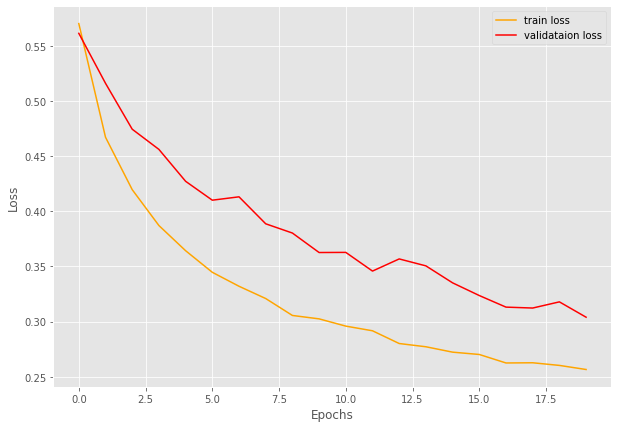

In [10]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test

In [13]:
test_csv = pd.read_csv('/content/drive/MyDrive/train/v2/test.csv')
types = test_csv.columns.values[2:]

test_data = ImageDataset(test_csv, train=False, test=True, path='/content/drive/MyDrive/train/v2/test')
test_loader = DataLoader(test_data, batch_size = 1, shuffle=False)

def compare(item1):
  return item1[1]

for counter, data in enumerate(test_loader):
    image, target = data['image'].to(device), data['label']
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]

    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()

    actuals = [types[v] for v in target_indices]
    predict_result = []
    
    print(f'Predict:')
    for i in range(len(outputs[0])):
        predict_result.append((types[i], outputs[0][i]))
    predict_result = sorted(predict_result, key=compare, reverse=True)
    
    for item in predict_result:
      print('{0} ({1:0.03f}%)'.format(item[0], item[1] * 100), end='')
      if item[0] in actuals:
        print(' O', end='')
      print('')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Predict:
ic31 (51.886%)
ic22 (46.965%) O
ic21 (35.460%)
ic12 (34.245%)
ic32 (14.661%) O
ic11 (9.811%)
Predict:
ic22 (28.310%) O
ic21 (20.030%)
ic12 (15.139%)
ic11 (10.870%)
ic32 (4.630%)
ic31 (4.579%)
Predict:
ic31 (62.398%) O
ic12 (32.031%) O
ic32 (21.864%)
ic22 (13.163%)
ic21 (13.125%)
ic11 (3.884%)
Predict:
ic31 (80.084%) O
ic12 (10.368%)
ic21 (8.186%)
ic22 (7.890%)
ic11 (6.145%)
ic32 (3.568%)
Predict:
ic22 (93.491%) O
ic12 (80.776%) O
ic31 (13.049%)
ic11 (8.014%)
ic32 (5.153%)
ic21 (2.693%)
Predict:
ic32 (54.130%) O
ic21 (50.460%) O
ic12 (26.221%)
ic31 (9.762%)
ic11 (7.742%)
ic22 (7.040%)
Predict:
ic12 (84.092%) O
ic21 (83.790%) O
ic32 (40.748%) O
ic22 (31.747%)
ic31 (14.626%)
ic11 (6.163%)
Predict:
ic31 (87.643%) O
ic12 (82.250%) O
ic22 (73.314%) O
ic21 (41.814%)
ic32 (8.473%)
ic11 (4.819%)
Predict:
ic32 (59.549%) O
ic12 (32.751%)
ic31 (18.662%)
ic22 (8.299%)
ic21 (7.467%)
ic11 (2.553%)
Predict:
ic12 (93.949%) O
ic31 (88.243%) O
ic21 (44.400%) O
ic22 (30.975%)
ic11 (14.223%)
ic32 